# Import Library

In [56]:
import os

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2


In [2]:
data_dir = "C:/Users/eliza/CLINICO-Medical-Chatbot/classification/Skin Desease Classification/Skin Desease Data"
print(os.listdir(data_dir))

['test_set', 'train_set']


In [5]:
inner_path = os.path.join(data_dir, "C:/Users/eliza/CLINICO-Medical-Chatbot/classification/Skin Desease Classification/Skin Desease Data")
print(os.listdir(inner_path))

['test_set', 'train_set']


# Inspect Data

(205, 205, 3)


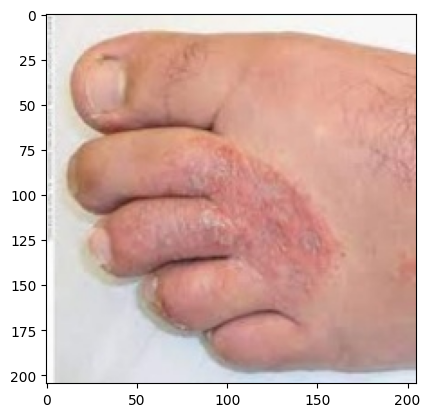

In [8]:
base_dir ='C:/Users/eliza/CLINICO-Medical-Chatbot/classification/Skin Desease Classification/Skin Desease Data/train_set'
image_path='C:/Users/eliza/CLINICO-Medical-Chatbot/classification/Skin Desease Classification/Skin Desease Data/train_set/FU-athlete-foot/FU-athlete-foot (1).jpeg'

img=mpimg.imread(image_path)
print(img.shape)

plt.imshow(img)
plt.axis()
plt.show()

# Data Preposcessing

In [65]:
img_size = 224
batch_size = 32

def resize_and_pad(img):
    desired_size = 224
    old_size = img.shape[:2]  

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img / 255.0  

data_gen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)

train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear',
    shuffle=True
)

valid_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Class sample counts:", np.bincount(train_gen.classes))

Found 695 images belonging to 8 classes.
Found 229 images belonging to 8 classes.
Class indices: {'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7}
Class sample counts: [102  60  93  97  68  75 102  98]


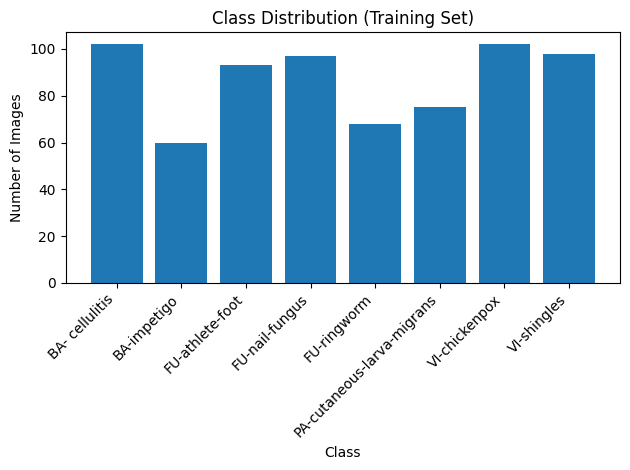

In [12]:
class_names = list(train_gen.class_indices.keys())

class_counts = np.bincount(train_gen.classes)

plt.figure()
plt.bar(class_names, class_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution (Training Set)")
plt.tight_layout()
plt.show()

## Handling class imbalance

Class Weights: {0: 0.8517156862745098, 1: 1.4479166666666667, 2: 0.9341397849462365, 3: 0.895618556701031, 4: 1.2775735294117647, 5: 1.1583333333333334, 6: 0.8517156862745098, 7: 0.8864795918367347}


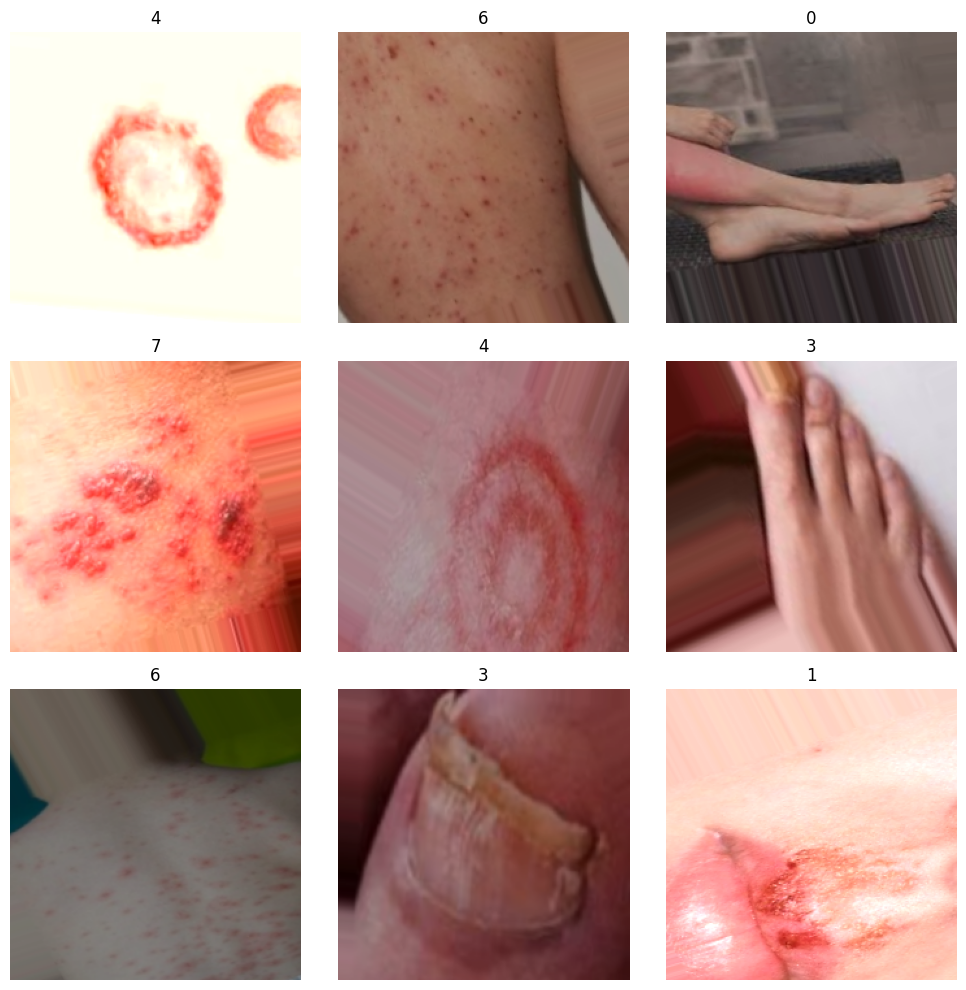

In [11]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Preview Images 
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Modeling

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 64)                81984     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 8)                 520       
                                                                 
Total params: 2,340,488
Trainable params: 82,504
Non-t

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [59]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.3,           
    patience=5,          
    min_lr=1e-6,
    verbose=1
)

In [60]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
22/22 [==============================] - 21s 832ms/step - loss: 1.7825 - accuracy: 0.3698 - val_loss: 1.1500 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - 37s 2s/step - loss: 1.0886 - accuracy: 0.6518 - val_loss: 0.8853 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - 33s 2s/step - loss: 0.8930 - accuracy: 0.6964 - val_loss: 0.6106 - val_accuracy: 0.8253 - lr: 0.0010
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.7012 - accuracy: 0.7827 - val_loss: 0.6232 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 5/20
22/22 [==============================] - 30s 1s/step - loss: 0.5612 - accuracy: 0.8201 - val_loss: 0.5065 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 6/20
22/22 [==============================] - 29s 1s/step - loss: 0.5268 - accuracy: 0.8360 - val_loss: 0.5099 - val_accuracy: 0.8253 - lr: 0.0010
Epoch 7/20
22/22 [==============================] - 28s 1s/step - loss: 0.5059 

# Evaluate Model

In [61]:
print("Evaluating model........")
val_loss,val_accuracy=model.evaluate(valid_gen,steps=valid_gen.samples//batch_size)
print(f"validation accuracy:{val_accuracy*100:.2f}%")

Evaluating model........
7/7 [==============================] - 7s 873ms/step - loss: 0.3863 - accuracy: 0.8884
validation accuracy:88.84%


In [62]:
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

print(classification_report(Y_true, Y_pred, target_names=valid_gen.class_indices.keys()))

8/8 [==============================] - 8s 791ms/step
                            precision    recall  f1-score   support

            BA- cellulitis       0.96      0.76      0.85        33
               BA-impetigo       0.94      0.85      0.89        20
           FU-athlete-foot       0.73      0.97      0.83        31
            FU-nail-fungus       1.00      0.94      0.97        32
               FU-ringworm       0.86      0.82      0.84        22
PA-cutaneous-larva-migrans       0.87      0.80      0.83        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       0.78      0.88      0.82        32

                  accuracy                           0.88       229
                 macro avg       0.89      0.88      0.88       229
              weighted avg       0.89      0.88      0.88       229



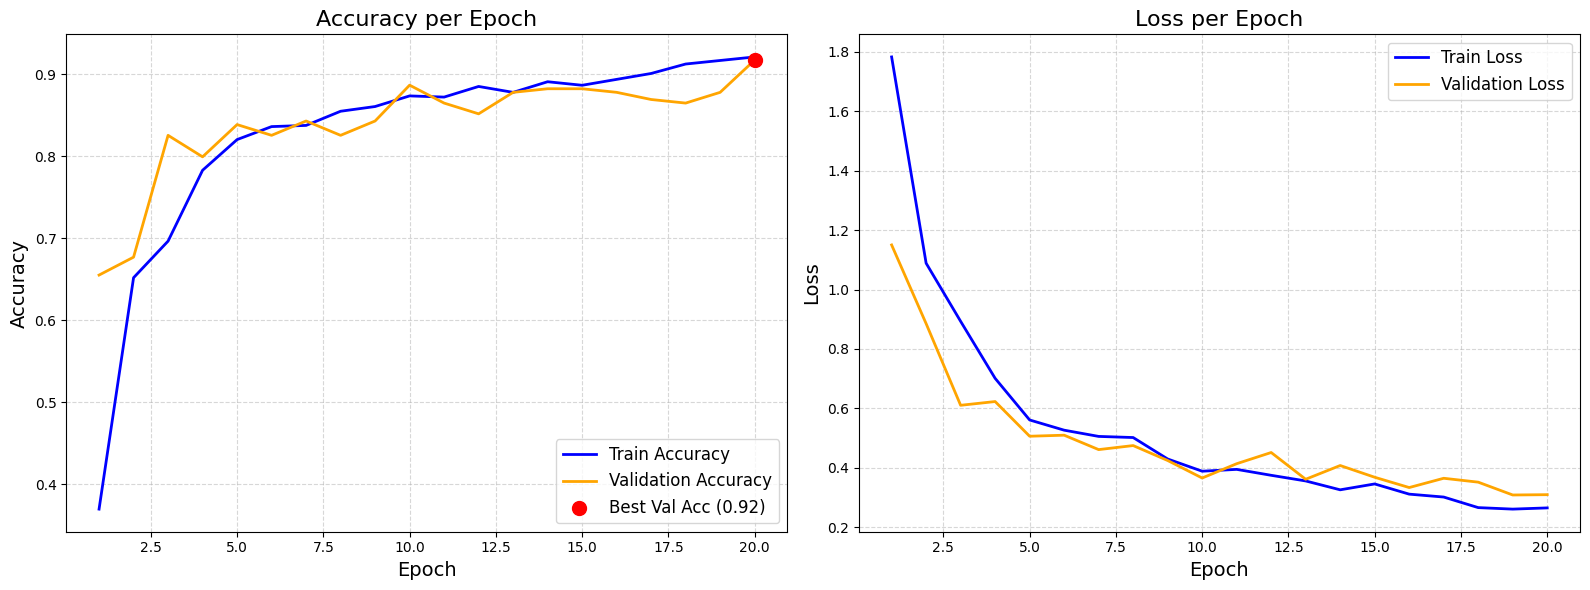

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Cari epoch terbaik
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# ----- Accuracy -----
axes[0].plot(epochs, train_acc, label='Train Accuracy', color='blue', linewidth=2)
axes[0].plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
axes[0].scatter(best_epoch+1, best_val_acc, color='red', s=100, zorder=5, label=f'Best Val Acc ({best_val_acc:.2f})')
axes[0].set_title('Accuracy per Epoch', fontsize=16)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# ----- Loss -----
axes[1].plot(epochs, train_loss, label='Train Loss', color='blue', linewidth=2)
axes[1].plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
axes[1].set_title('Loss per Epoch', fontsize=16)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
